# 数据增强
增加一个已有数据集，使得有更多的多样性在语言里面加入各种不同的背景噪音改变图片的颜色和形状
## 翻转
·左右翻转
·上下翻转
 · 不总是可行

## 切割
从图片中切割一块，然后变形到固定形状
随机高宽比(e.g.[3/4,4/3])
随机大小(e.g.[8%,100%])
随机位置

# 总结
数据增广通过变形数据来获取多样性从而使得模型泛化性能更好常见图片增广包括翻转、切割、变色

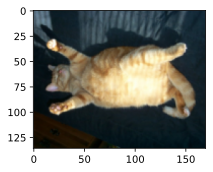

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('F:\desktop\基础知识\论文&代码\动手学深度学习\\36 数据增广\cat.png')
d2l.plt.imshow(img);

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

## 左右翻转图像

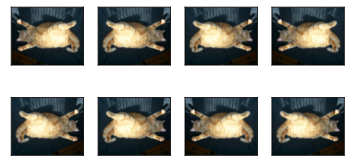

In [3]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

## 上下翻转图像

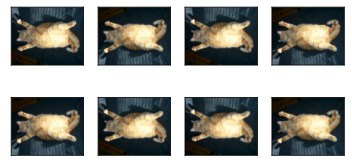

In [4]:
apply(img, torchvision.transforms.RandomVerticalFlip())

## 随机裁剪

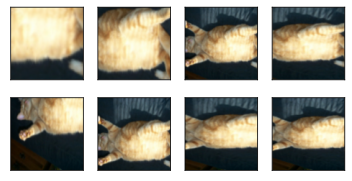

In [5]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

## 随机更改图像的亮度

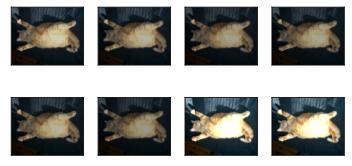

In [6]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))

## 随机更改图像的色调

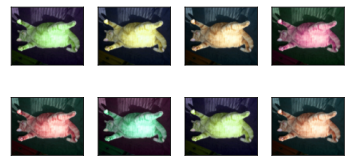

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))

## 随机更改图像的亮度(brightness)、对比度(contrast）、饱和度(saturation)和色调(hue)

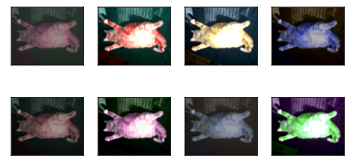

In [8]:
coloe_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, coloe_aug)

## 结合多种图像增广方法

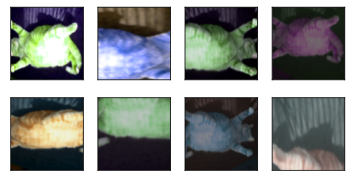

In [9]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    coloe_aug, shape_aug])
apply(img, augs)

## 使用图像增广进行训练

In [10]:
all_images = torchvision.datasets.CIFAR10(
    train=True, root='../data', download=True)
d2l.show_images([
    all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

  0%|          | 0/170498071 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 只使用简单的随机左右翻转

In [11]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

## 定义一个辅助函数，以便于读取图像和应用图像增广

In [16]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='../data', train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=4)
    return dataloader

## 定义一个函数，使用多GPU对模型进行训练和评估

In [12]:
def train_batch_chl3(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    """使用多GPU进行训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：存储训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_chl3(net, features, labels, loss, trainer, devices)
            metric.add(1, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches -1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

# 训练模型

In [17]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)


def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)


net.apply(init_weights)


def train_with_data_aug(train_augs, test_augs, net, lr=0.01):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [18]:
train_with_data_aug(train_augs, test_augs, net)

  0%|          | 0/170498071 [00:00<?, ?it/s]

KeyboardInterrupt: 